<a href="https://colab.research.google.com/github/yangjiwoong1/brief-lab/blob/main/notebooks/news_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 EDA
- [연합뉴스](https://www.yna.co.kr/)에서 크롤링한 최신뉴스 데이터에 대해 EDA를 진행
- EDA의 주 목적은 크롤링 후 파싱하여 저장된 뉴스 데이터에 대하여 다음 내용을 확인함에 있음
    - 결측치, 중복 데이터 확인
    - 문서 길이 분포를 파악하여 사전 RAG DB 구축을 위한 청킹 파라미터를 결정(청크 길이, 청크 오버랩 크기).
    - 의도했던대로 뉴스 기사가 파싱됐는지 확인
        - 뉴스 기사 HTML에서 본문 내용의 텍스트만 파싱

## 크롤링 데이터셋
- 서비스의 실용성을 생각하면 주기적으로 뉴스 데이터를 받아와야하고 많은 데이터를 가지고 EDA를 진행해야 하지만 시간 관계 상 특정 타임에 크롤링한 데이터를 기준으로 EDA 진행
- 먼저 2025/06/17 10:34분 시점에 크롤링한 데이터를 기준으로 EDA 진행

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 2025/06/17 10:34분 기점 크롤링한 데이터
df = pd.read_json("/content/news_items0.json")

df.head()

,title,summary,content,link,published,author,image_url,timestamp
0,"슈퍼브에이아이, 비전 AI 학회 챌린지 준우승",(서울=연합뉴스) 김경희 기자 = 슈퍼브에이아이는 17일 컴퓨터 비전 분야 최대 학...,(서울=연합뉴스) 김경희 기자 = 슈퍼브에이아이는 17일 컴퓨터 비전 분야 최대 학...,https://www.yna.co.kr/view/AKR20250617060800017,"Tue, 17 Jun 2025 10:28:20 +0900",,https://img.yna.co.kr/etc/inner/KR/2025/06/17/...,2025-06-17 10:33:33.992589
1,"[1보] 헌재, 조지호 탄핵심판 준비절차 회부…7월 1일 준비기일",(,제보는 카카오톡 okjebo,https://www.yna.co.kr/view/AKR20250617062400004,"Tue, 17 Jun 2025 10:28:18 +0900",,https://img.yna.co.kr/photo/yna/YH/2024/12/09/...,2025-06-17 10:33:34.856215
2,"aT, 중동 K푸드 진출 거점 구축…두바이에 민관 협업센터",(서울=연합뉴스) 김윤구 기자 = 한국농수산식품유통공사(aT)는 중동 K푸드 시장 ...,(서울=연합뉴스) 김윤구 기자 = 한국농수산식품유통공사(aT)는 중동 K푸드 시장 ...,https://www.yna.co.kr/view/AKR20250617062200030,"Tue, 17 Jun 2025 10:28:03 +0900",,https://img.yna.co.kr/etc/inner/KR/2025/06/17/...,2025-06-17 10:33:35.371646
3,"""내가 전부 고칠 수 있다""…48㎝ 장침으로 무면허 침시술한 70대",(제주=연합뉴스) 변지철 기자 = 한의사 면허 없이 전국을 돌아다니며 침 시술을 행...,(제주=연합뉴스) 변지철 기자 = 한의사 면허 없이 전국을 돌아다니며 침 시술을 행...,https://www.yna.co.kr/view/AKR20250617058900056,"Tue, 17 Jun 2025 10:27:10 +0900",,https://img.yna.co.kr/etc/inner/KR/2025/06/17/...,2025-06-17 10:33:35.924272
4,[대구소식] 달성군장애인복지관 '그린 리모델링' 33억원 투입,(대구=연합뉴스) 대구 달성군은 국토교통부 주관 2025년도 공공건축물 그린 리모델...,(대구=연합뉴스) 대구 달성군은 국토교통부 주관 2025년도 공공건축물 그린 리모델...,https://www.yna.co.kr/view/AKR20250617061900053,"Tue, 17 Jun 2025 10:27:06 +0900",,https://img.yna.co.kr/etc/inner/KR/2025/06/17/...,2025-06-17 10:33:36.131280


In [2]:
# 제목 또는 기사 링크를 기준으로 중복데이터 판단
link_dup = df.duplicated(subset=["link"], keep=False)
title_dup = df.duplicated(subset=["title"], keep=False)

print("중복 기사 갯수: {}".format((link_dup | title_dup).sum())) # 중복된 행 개수를 출력
print("결측치가 포함된 행 갯수: {}".format(df.isna().any(axis=1).sum()))

중복 기사 갯수: 0
결측치가 포함된 행 갯수: 0


In [3]:
# 길이 분포 확인을 위한 Series 생성
content_len_df = df["content"].str.len() # Series
content_len_df = content_len_df.rename('content_length')

content_len_df.head()

,content_length
0,528
1,15
2,631
3,776
4,338


In [4]:
# 기본적인 통계치 출력
content_len_df.describe()

,content_length
count,120.000000
mean,710.100000
std,415.557384
min,15.000000
25%,456.500000
50%,623.500000
75%,841.750000
max,2646.000000


<Axes: xlabel='content_length', ylabel='Density'>

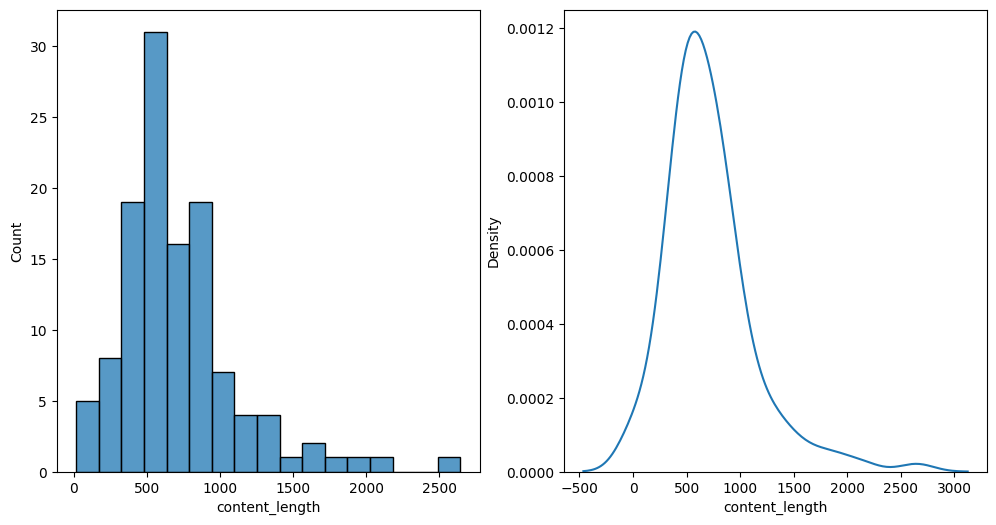

In [5]:
# 그래프 시각화
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(content_len_df, ax=ax[0])
sns.kdeplot(content_len_df, ax=ax[1])

## 길이 분석 내용
평균은 약 710자이며, 25번째 백분위수(Q1)와 75번째 백분위수(Q3)는 각각 456자, 841자로 평균과 크게 차이나지 않는다.

그러나 표준편차가 415로 상당히 크며, 이를 68–95–99.7 법칙에 따라 분석하면 다음과 같다.

| 구간 범위       | 하한      | 상한       | 포함 비율   |
| ----------- | ------- | -------- | ------- |
| 1σ (±1 std) | 294.54  | 1,125.66 | 약 68%   |
| 2σ (±2 std) | −121.02 | 1,541.22 | 약 95%   |
| 3σ (±3 std) | −536.58 | 1,956.78 | 약 99.7% |

일부 하한값이 0보다 작게 계산되지만, 실제 데이터에서는 음수가 될 수 없으므로 이는 오른쪽으로 꼬리가 긴 분포(positive skewness)를 나타낸다. 이는 위의 KDE 그래프에서도 확인할 수 있다.

최대값이 2,646자에 이르는 것을 고려하면, 동일한 언론사 내에서도 기사에 따라 길이 차이가 크게 발생할 수 있음을 알 수 있다.

최솟값은 15자인데, 일반적으로 뉴스 기사의 길이로는 매우 짧은 편이다. 따라서 이처럼 짧은 기사는 실제 기사 내용이 제대로 작성되지 않았거나 이상이 있을 가능성이 크다고 판단할 수 있다.

In [6]:
# 최대 길이의 본문 내용 직접 확인해보기
length_max_idx = content_len_df.idxmax(axis=0)
df["content"].loc[length_max_idx]

'(서울=연합뉴스) 황철환 기자 = 이스라엘의 기습적 선제공격으로 시작된 이란과의 무력 충돌이 닷새째에 접어든 가운데 양국은 이날도 스텔스기 등을 동원한 정밀 폭격과 미사일 세례를 주고받으며 교전을 이어갔다.\n이스라엘은 이란 정권교체를 거론하며 아야톨라 세예드 알리 하메네이 최고지도자를 정조준할 태세까지 보인다. 상황이 심각해지자 주요 7개국(G7) 정상회의에 참석 중이던 도널드 트럼프 미국 대통령은 조기귀국하기로 했으며, 국가안전보장회의(NSC) 소집 준비를 지시한 것으로 전해졌다.\n트럼프 대통령의 급거 귀국 결정으로 이스라엘-이란의 충돌이 더 격화되는 새로운 상황이 전개되는 것 아니냐는 우려가 커지고 있다.\n이스라엘군(IDF)은 17일(현지시간) 오전 0시 55분께 텔레그램을 통해 이란에서 발사된 미사일이 탐지돼 전국 각지에 공습 경보가 내려졌다고 밝혔다.\n미사일을 요격하는 동시에 위협 제거를 위한 공습에 착수했다고 밝힌 이스라엘군은 약 20분만에 경보를 해제하고 "이제 전국에서 보호 공간(shelter)을 떠나는게 허용된다"고 공지했다.\n전날 밤 이란 국영 IRNA 통신은 이스라엘을 겨냥해 다수의 미사일과 드론(무인기)가 발사됐다고 보도했는데, 정황상 대부분이 비행 중 격추된 것으로 보인다.\n이에 앞서 이스라엘군은 16일 저녁 이란 수도 테헤란에 위치한 국영 IRIB 방송국 본사를 두 차례에 걸쳐 공습했다. 이스라엘군은 해당 건물에 군사 시설이 숨겨져 있었다고 주장했다.\n또, 이스라엘 전투기를 요격하려고 테헤란의 한 공항에 배치됐던 이란 공군 소속 F-14 전투기 두 기가 공습에 파괴됐고, 테헤란에 있는 이슬람혁명수비대(IRGC) 정예 쿠드스군 사령부도 폭격을 받았다.\n이스라엘군은 공습을 시작한 13일 이후 약 120대의 지대지 미사일 발사대를 무력화했다면서 이는 이란이 보유한 미사일 발사대의 3분의 1에 해당한다고 말했다. 이란 역시 매일 밤마다 이스라엘을 겨냥해 대량의 미사일과 드론을 발사하는 등 저항을 멈추지 않고 있다.\n이스라엘군은

In [7]:
# 최소 길이의 본문 내용 직접 확인해보기
length_min_idx = content_len_df.idxmin(axis=0)
df["content"].loc[length_min_idx]

'제보는 카카오톡 okjebo'

길이가 가장 짧은(길이 15) 기사를 직접 확인 했을 때 제대로 된 본문 내용이 없는 것을 발견했다.

In [8]:
n = 10  # content(본문) 길이 하위 n개에 대한 길이와 기사 내용 확인
smallest_idxs = content_len_df.nsmallest(n).index

for i in smallest_idxs:
    print(f"인덱스 {i}의 내용 길이: {content_len_df.loc[i]}")
    print(df["content"].loc[i])
    print("="*40)

인덱스 1의 내용 길이: 15
제보는 카카오톡 okjebo
인덱스 28의 내용 길이: 15
제보는 카카오톡 okjebo
인덱스 31의 내용 길이: 15
제보는 카카오톡 okjebo
인덱스 36의 내용 길이: 15
제보는 카카오톡 okjebo
인덱스 38의 내용 길이: 15
제보는 카카오톡 okjebo
인덱스 45의 내용 길이: 222
▲ 로보락은 서울 서초구에 있는 신세계백화점 강남점에서 이달 29일까지 세계 최초로 5축 접이식 로봇 팔을 탑재한 로봇청소기 '사로스(Saros) Z70' 팝업스토어를 연다고 17일 밝혔다. 팝업스토어는 '프롬 더 문'(FROM THE MOON) 콘셉트로, 달에 위치한 비밀 연구기지에서 탄생한 사로스 Z70의 독창적인 스토리를 방문객들에게 소개한다. (서울=연합뉴스)
제보는 카카오톡 okjebo
인덱스 21의 내용 길이: 231
▲ 골든블루는 '2025 샌프란시스코 주류품평회'에 출품한 '골든블루 쿼츠', '골든블루 더 사피루스', '골든블루 더 다이아몬드', '팬텀 디 오리지널 17', '팬텀 디 오리지널 리저브' 등 5개 제품이 모두 은상 또는 동상을 받았다고 17일 밝혔다. 이 품평회에서 골든블루 더 사피루스와 골든블루 더 다이아몬드는 11년 연속, 팬텀 시리즈는 6년 연속 입상했다. (부산=연합뉴스)
제보는 카카오톡 okjebo
인덱스 92의 내용 길이: 267
▲ 한국토지주택공사(LH)는 오는 18일 대전 KW컨벤션에서 '지역·주택 정책 방향 모색'을 주제로 정책 토론회를 연다고 17일 밝혔다. LH 토지주택연구원과 한국도시재생학회가 공동으로 주관하는 이번 행사는 지방 인구 감소, 수도권 집중 완화 문제를 해소하는 정책 방향을 논의할 목적으로 기획됐다. 발표는 일본 지역 정책의 시사점, 지방 인구 감소와 관련한 중소도시의 역할 강화 방안, 청년 주거 정책 방향 모색을 주제로 진행된다. (서울=연합뉴스)
제보는 카카오톡 okjebo
인덱스 57의 내용 길이: 268
▲ 통계청은 7∼8월 전국 초·중·고 교사를 대상으로 통계

본문 길이 하위 5개 항목의 내용이 누락된 것을 확인했다. 원인을 파악하기 위해 원문 기사를 찾아보았다.
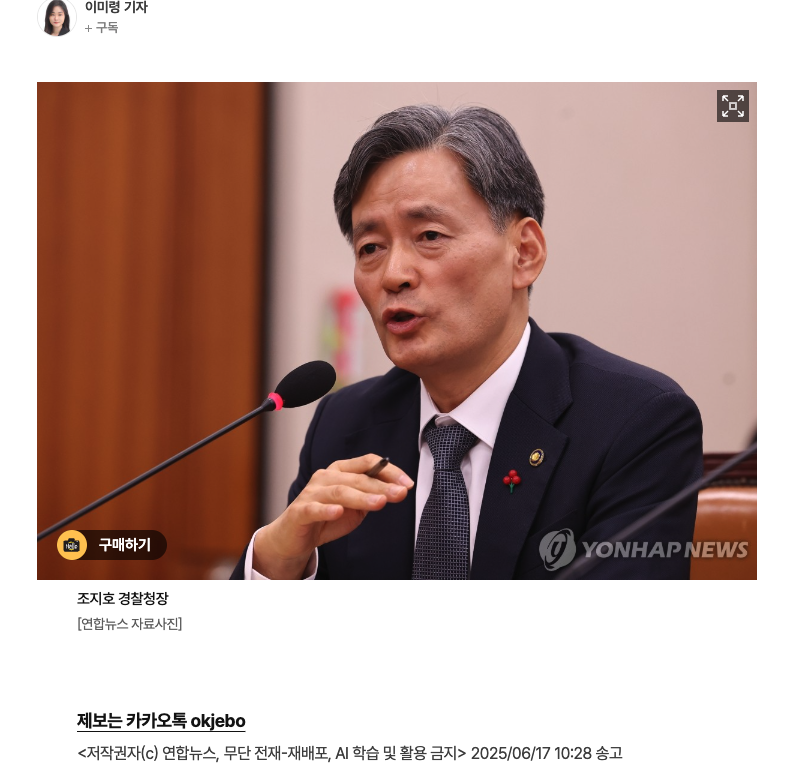


내용이 누락된 이유는 본문에 사진만 존재했기 때문이었다. 크롤링 할 때 사진을 제외한 본문 텍스트만 가져오도록 하였는데 위와 같이 사진만 존재하는 경우도 있음을 확인하였다.

In [9]:
# 본문 길이가 15인 행 삭제
df = df[df['content'].str.len() != 15].reset_index(drop=True)

# content_len_df도 df 기준으로 다시 계산
content_len_df = df['content'].str.len()

content_len_df.describe() # 최솟값 15 -> 222

,content
count,115.000000
mean,740.321739
std,397.679774
min,222.000000
25%,486.000000
50%,631.000000
75%,858.000000
max,2646.000000


## 결론
**데이터 전처리 측면**
+ 본문 내용이 없는 기사나 너무 짧은 기사는 신뢰할 수 없는 정보를 전달할 수 있으므로 전처리 단계에서 제거한다.
+ 본 데이터 기준으로, 정상적인 기사로 판단되는 최소 길이는 약 222자이며, 이를 고려해 100자 미만의 기사는 제거 대상으로 설정한다.

**RAG를 위한 벡터 DB 구축 시 파라미터 결정**
+ `chunk_size`는 1000정도로 설정하여, **되도록 하나의 청크에 기사가 다 담기도록** 한다.
+ 길이가 1000보다 길 경우 본 데이터 기준에서는 같은 기사에서 최대 3개 이상의 청크가 나올 수 있다(최대 길이가 2646이기 때문). 이를 `chunk_overlap`을 200정도로 설정하여 청크 간 문맥이 유지될 수 있도록 한다.

이후 데이터가 많아지면 본문 길이의 threshold를 세밀하게 조절할 수 있다.
또한 벡터 DB 용량, 검색의 정확성과 속도를 고려하여 파라미터를 재조정할 수도 있다.

## (참고) 다른 시점에서 크롤링한 데이터로 EDA 진행
앞선 EDA 결과는 특정 시점(2025년 6월 17일 10시 34분 기준)에서 수집한 데이터에 기반한 것으로, 일반화하기엔 한계가 존재한다.

이에 보다 보편적인 경향을 확인하기 위해, 동일한 방식으로 다른 시점(2025년 6월 17일 12시 50분 기준)에 크롤링한 데이터를 대상으로 동일한 분석을 반복하였다.

이 두 시점의 데이터는 서로 겹치는 기사가 없으며, 분석 결과 또한 전반적으로 유사한 경향을 보였다.

In [10]:
# 2025/06/17 12:50분 기점 크롤링한 데이터
df = pd.read_json("/content/news_items1.json")

df.head()

,title,summary,content,link,published,author,image_url,timestamp
0,"""美, 이란과 이번 주중 양자회담 가능성 논의 중""",(서울=연합뉴스) 황철환 기자 = 도널드 트럼프 미국 대통령의 중동특사인 스티브 위...,(서울=연합뉴스) 황철환 기자 = 도널드 트럼프 미국 대통령의 중동특사인 스티브 위...,https://www.yna.co.kr/view/AKR20250617084900009,"Tue, 17 Jun 2025 12:44:19 +0900",,https://img.yna.co.kr/photo/reuters/2025/06/17...,2025-06-17 12:49:04.318105
1,"오동운 공수처장 ""계엄수사 미흡 송구…특검 수사 협조 최선""(종합)",(서울·과천=연합뉴스) 김다혜 권희원 기자 = 오동운 고위공직자범죄수사처장은 취임 ...,(서울·과천=연합뉴스) 김다혜 권희원 기자 = 오동운 고위공직자범죄수사처장은 취임 ...,https://www.yna.co.kr/view/AKR20250617046651004,"Tue, 17 Jun 2025 12:38:45 +0900",,https://img.yna.co.kr/photo/yna/YH/2025/06/17/...,2025-06-17 12:49:05.044454
2,공무원 명함보고 믿었는데 알고보니 사기꾼…2천400만원 피해(종합),(부산=연합뉴스) 김재홍 기자 = 전국적으로 공무원을 사칭한 사기 범죄 신고가 잇따...,(부산=연합뉴스) 김재홍 기자 = 전국적으로 공무원을 사칭한 사기 범죄 신고가 잇따...,https://www.yna.co.kr/view/AKR20250617054351051,"Tue, 17 Jun 2025 12:37:16 +0900",,https://img.yna.co.kr/photo/cms/2025/05/08/26/...,2025-06-17 12:49:05.707075
3,[속보] 일본은행 기준금리 3회 연속 동결…0.5%로 유지,(,제보는 카카오톡 okjebo,https://www.yna.co.kr/view/AKR20250617084800073,"Tue, 17 Jun 2025 12:34:12 +0900",,https://img.yna.co.kr/photo/cms/2023/08/24/52/...,2025-06-17 12:49:06.681471
4,"[속보] 대통령실 ""한일 정상회담, 내일 오후 개최로 정해져""",(,제보는 카카오톡 okjebo,https://www.yna.co.kr/view/AKR20250617084700001,"Tue, 17 Jun 2025 12:32:42 +0900",,https://img.yna.co.kr/photo/cms/2023/08/24/52/...,2025-06-17 12:49:07.566646


In [11]:
# 제목 또는 기사 링크를 기준으로 중복데이터 판단
link_dup = df.duplicated(subset=["link"], keep=False)
title_dup = df.duplicated(subset=["title"], keep=False)

print("중복 기사 갯수: {}".format((link_dup | title_dup).sum())) # 중복된 행 개수를 출력
print("결측치가 포함된 행 갯수: {}".format(df.isna().any(axis=1).sum()))

중복 기사 갯수: 0
결측치가 포함된 행 갯수: 0


In [12]:
# 길이 분포 확인을 위한 Series 생성
content_len_df = df["content"].str.len() # Series
content_len_df = content_len_df.rename('content_length')

content_len_df.head()

,content_length
0,1241
1,2133
2,986
3,15
4,15


In [13]:
# 기본적인 통계치 출력
content_len_df.describe()

,content_length
count,119.000000
mean,941.647059
std,549.721048
min,15.000000
25%,598.500000
50%,858.000000
75%,1229.500000
max,2991.000000


<Axes: xlabel='content_length', ylabel='Density'>

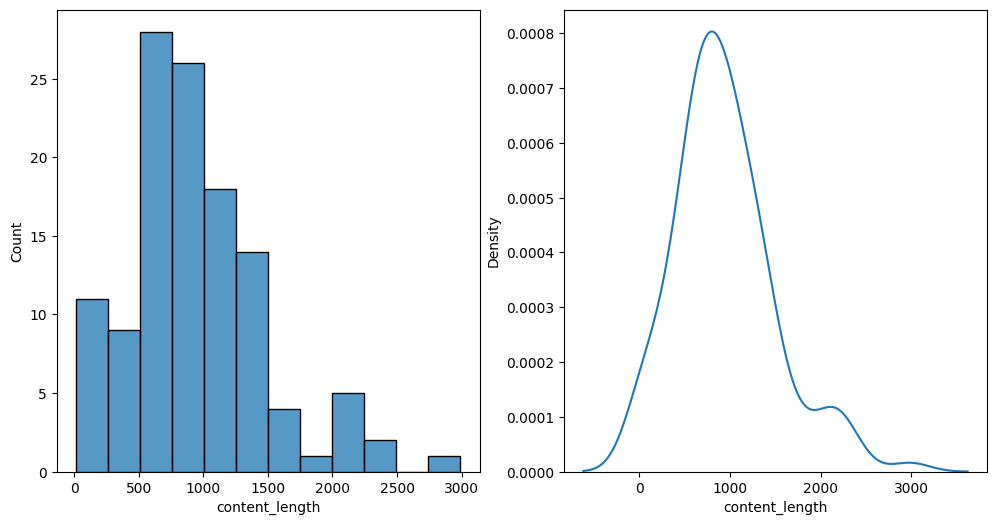

In [14]:
# 그래프 시각화
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(content_len_df, ax=ax[0])
sns.kdeplot(content_len_df, ax=ax[1])

In [15]:
# 최대 길이의 본문 내용 직접 확인해보기
length_max_idx = content_len_df.idxmax(axis=0)
df["content"].loc[length_max_idx]

'(서울=연합뉴스) 황철환 기자 = 이스라엘의 기습적 선제공격으로 시작된 이란과의 무력 충돌이 닷새째로 치닫는 와중에 양국은 이날도 스텔스기 등을 동원한 정밀 폭격과 미사일 세례를 주고받으며 교전을 이어갔다.\n이스라엘은 이란 정권교체를 거론하며 아야톨라 세예드 알리 하메네이 최고지도자를 정조준할 태세까지 보인다. 상황이 심각해지자 주요 7개국(G7) 정상회의에 참석 중이던 도널드 트럼프 미국 대통령은 조기 귀국하기로 했으며, 국가안전보장회의(NSC) 소집 준비를 지시한 것으로 전해졌다.\n트럼프 대통령의 급거 귀국 결정으로 이스라엘-이란의 충돌이 더 격화되는 새로운 상황이 전개되는 것 아니냐는 우려가 커지고 있다. CBS 방송은 트럼프 대통령과 함께 마코 루비오 미 국무장관도 함께 백악관으로 복귀 중이라고 보도했다.\n이스라엘군(IDF)은 17일(현지시간) 오전 0시 55분께 텔레그램을 통해 이란에서 발사된 미사일이 탐지돼 전국 각지에 공습 경보가 내려졌다고 밝혔다.\n미사일을 요격하는 동시에 위협 제거를 위한 공습에 착수했다고 밝힌 이스라엘군은 약 20분만에 경보를 해제하고 "이제 전국에서 보호 공간(shelter)을 떠나는게 허용된다"고 공지했다.\n전날 밤 이란 국영 IRNA 통신은 이스라엘을 겨냥해 다수의 미사일과 드론(무인기)가 발사됐다고 보도했는데, 정황상 대부분이 비행 중 격추된 것으로 보인다.\n이에 앞서 이스라엘군은 16일 저녁 이란 수도 테헤란에 위치한 국영 IRIB 방송국 본사를 두 차례에 걸쳐 공습했다. 이스라엘군은 해당 건물에 군사 시설이 숨겨져 있었다고 주장했다.\n또, 이스라엘 전투기를 요격하려고 테헤란의 한 공항에 배치됐던 이란 공군 소속 F-14 전투기 두 기가 공습에 파괴됐고, 테헤란에 있는 이슬람혁명수비대(IRGC) 정예 쿠드스군 사령부도 폭격을 받았다.\n이스라엘군은 공습을 시작한 13일 이후 약 120대의 지대지 미사일 발사대를 무력화했다면서 이는 이란이 보유한 미사일 발사대의 3분의 1에 해당한다고 말했다. 이란 역시 

In [16]:
# 최소 길이의 본문 내용 직접 확인해보기
length_min_idx = content_len_df.idxmin(axis=0)
df["content"].loc[length_min_idx]

'제보는 카카오톡 okjebo'

In [17]:
n = 10  # content(본문) 길이 하위 n개에 대한 길이와 기사 내용 확인
smallest_idxs = content_len_df.nsmallest(n).index

for i in smallest_idxs:
    print(f"인덱스 {i}의 내용 길이: {content_len_df.loc[i]}")
    print(df["content"].loc[i])
    print("="*40)

인덱스 3의 내용 길이: 15
제보는 카카오톡 okjebo
인덱스 4의 내용 길이: 15
제보는 카카오톡 okjebo
인덱스 5의 내용 길이: 15
제보는 카카오톡 okjebo
인덱스 6의 내용 길이: 15
제보는 카카오톡 okjebo
인덱스 7의 내용 길이: 15
제보는 카카오톡 okjebo
인덱스 8의 내용 길이: 15
제보는 카카오톡 okjebo
인덱스 11의 내용 길이: 132
▲ 심정자씨 별세, 여은주(GS스포츠 대표이사)씨 장모상 = 17일 오전 7시 10분, 한양대병원 장례식장 7호실, 발인 19일 오전 7시 40분, 장지 영락동산. ☎ 02-2290-9457 (서울=연합뉴스)
제보는 카카오톡 okjebo
인덱스 38의 내용 길이: 178
▲ 국가인권위원회(인권위)는 23일 오후 2시 서울 영등포구 이룸센터 누리홀에서 '2025년 장애인 인권증진 토론회'를 연다. '발달 장애인의 형사 사법 과정에서의 차별 시정'을 주제로 장애인차별금지법, 발달장애인법 등 발달장애인 관련 사법 절차 법령의 실효성을 점검한다. (서울=연합뉴스)
제보는 카카오톡 okjebo
인덱스 28의 내용 길이: 182
▲ 서울시교육청은 19일 이화여고 100주년 기념관에서 인공지능(AI) 관련 서울 교육의 방향을 논의하는 'AI 인재양성 심포지엄'을 개최한다고 17일 밝혔다. 교육계와 AI 산업계 종사자 등 200여명이 참석해 초·중·고 AI 인재상을 함께 나누고 관련 정책을 토론할 예정이다. (서울=연합뉴스)
제보는 카카오톡 okjebo
인덱스 32의 내용 길이: 200
▲ 개인정보보호위원회는 18∼19일 캐나다 오타와에서 열리는 '주요 7개국 개인정보 감독기구 라운드테이블(G7 DPA Roundtable)'에 고학수 위원장이 참석해 G7 개인정보 감독기관장 등과 인공지능(AI), 양자컴퓨팅 등 신기술 분야와 글로벌 AI 데이터 거버넌스에 관해 폭넓게 논의한다고 17일 밝혔다. (서울=연합뉴스)
제보는 카카오톡 okjebo


In [18]:
# 본문 길이가 15인 행 삭제
df = df[df['content'].str.len() != 15].reset_index(drop=True)

# content_len_df도 df 기준으로 다시 계산
content_len_df = df['content'].str.len()

content_len_df.describe() # 최솟값 15 -> 132

,content
count,113.000000
mean,990.849558
std,519.556752
min,132.000000
25%,616.000000
50%,912.000000
75%,1240.000000
max,2991.000000
